**Question 6 : On fait de notre mieux !**

Voici par étape, le plan que nous suivrons pour répondre à la question 6:<br>
<br>
- 1. Préparation des données<br>
Nettoyage<br>
Sélection de caractéristiques (Random Forest)<br>
Division des données (scénarios avancés)<br>
Essayez différentes stratégies pour diviser les données d’entraînement et de validation :<br>
Divisez les matchs selon des périodes spécifiques (par exemple, ignorez les 20 premiers matchs de chaque équipe).<br>
Effectuez une validation croisée stratifiée sur game_id.<br>

- 2.  Modèles à tester<br>
Approche 1 : Régression logistique (baseline simple)<br>
optimiser les hyperparametres<br>
<br>
Approche 2 : Testez un modèle d'arbre de décision ou Random Forest.<br>
Explorez l'importance des caractéristiques pour voir si certains paramètres influencent fortement le résultat.<br>
Ajoutez une recherche d'hyperparamètres pour optimiser la profondeur, le nombre d'arbres, etc.<br>
optimiser les hyperparametres<br>
<br>
Approche 3 : Réseau de neurones avec 2-3 couches cachées.<br>
Dropout pour la régularisation.<br>
Fonction d'activation ReLU pour les couches cachées et Sigmoïde pour la sortie.<br>
Normalisez les entrées avant l'entraînement.<br>
Testez avec différents taux d’apprentissage.<br>
optimiser les hyperparametres<br>
<br>
Approche 4 : Gradient Boosting ( LightGBM)<br>
Peut gérer des données déséquilibrées (avec ajustement des poids des classes).
Avantages :
Efficace sur des ensembles de données tabulaires.
Flexible grâce à de nombreux hyperparamètres (mais attention à ne pas sur-ajuster).
Limitation : Plus lent à entraîner que la régression logistique ou les forêts aléatoires.
- 3. Nouvelles Métrics<br>
F1-score : Mesure l'équilibre entre précision et rappel.<br>


In [67]:
# Récupération des données
import sys
sys.path.append('../controller/')
from nhl_data_loader import NHLDataLoader
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

In [6]:
loader = NHLDataLoader()

In [7]:
#Acquisition des données.
df = loader.load_csv_files_only_shot_events([2016, 2017, 2018, 2019, 2020])

In [8]:
df

,game_id,game_date,home_team_id,period,time_in_period,event_id,event_type,is_goal,shot_type,x_coord,...,last_x_coord,last_y_coord,time_since_last_event,distance_from_last_event,rebound,home_team_defending_side,shooting_distance,shot_angle,rebound_angle,speed_from_last_event
0,2016020518,2016-12-27,2,1,01:09,55,shot-on-goal,False,backhand,85.0,...,34.0,-29.0,4.0,63.007936,False,right,8.944272,153.434949,NaN,15.751984
1,2016020518,2016-12-27,2,1,02:38,58,shot-on-goal,False,tip-in,-71.0,...,-73.0,-9.0,25.0,5.385165,False,right,18.439089,102.528808,NaN,0.215407
2,2016020518,2016-12-27,2,1,03:44,61,shot-on-goal,False,slap,-36.0,...,61.0,-40.0,6.0,119.037809,False,right,60.415230,61.313852,NaN,19.839635
3,2016020518,2016-12-27,2,1,04:12,64,shot-on-goal,False,wrist,-70.0,...,-61.0,-38.0,0.0,41.976184,False,right,19.235384,81.027373,NaN,inf
4,2016020518,2016-12-27,2,1,04:21,67,shot-on-goal,False,tip-in,-72.0,...,-77.0,0.0,0.0,5.830952,False,right,17.262677,79.992020,NaN,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385054,2020020353,2021-03-01,28,3,10:57,741,shot-on-goal,False,wrist,-38.0,...,-73.0,20.0,8.0,37.000000,False,left,51.623638,81.085073,NaN,4.625000
385055,2020020353,2021-03-01,28,3,18:10,757,shot-on-goal,False,wrist,-51.0,...,-20.0,22.0,22.0,32.280025,False,left,49.040799,50.792796,NaN,1.467274
385056,2020020353,2021-03-01,28,3,18:36,759,shot-on-goal,False,wrist,-55.0,...,-38.0,19.0,7.0,18.384776,False,left,36.055513,70.559965,NaN,2.626397
385057,2020020353,2021-03-01,28,3,18:45,761,shot-on-goal,False,wrist,-43.0,...,-69.0,22.0,8.0,27.513633,False,left,55.470713,56.023456,NaN,3.439204


**Nettoyage**

In [9]:
#Ici on regarde les colonnes qui contiennent des NAN
nan_columns = df.columns[df.isna().any()]
print(nan_columns)

Index(['shot_type', 'goalie_id', 'time_since_last_event',
       'distance_from_last_event', 'rebound_angle', 'speed_from_last_event'],
      dtype='object')


In [10]:
# on supprime les types de tirs inconnus
df = df.dropna(subset=['shot_type'])
# On met les goalie à 2 (prit au pif car cet attribue ne semble pas intervenir dans l'étude)
df['goalie_id'] = df['goalie_id'].fillna(2)
# On met les angles de rebound à 0 quand il n'y a pas d'angle de rebond
df['rebound_angle'] = df['rebound_angle'].fillna(0)


/tmp/ipykernel_12035/4199152658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goalie_id'] = df['goalie_id'].fillna(2)
/tmp/ipykernel_12035/4199152658.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rebound_angle'] = df['rebound_angle'].fillna(0)


In [11]:
#Ici on regarde les colonnes qui contiennent des NAN
nan_columns = df.columns[df.isna().any()]
print(nan_columns)

Index(['time_since_last_event', 'distance_from_last_event',
       'speed_from_last_event'],
      dtype='object')


In [12]:
df['time_since_last_event'] = df['time_since_last_event'].fillna(0)  # Remplacer NaN par 0
df['distance_from_last_event'] = df['distance_from_last_event'].fillna(0)
df['speed_from_last_event'] = df['speed_from_last_event'].fillna(0)

/tmp/ipykernel_12035/558554114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_since_last_event'] = df['time_since_last_event'].fillna(0)  # Remplacer NaN par 0
/tmp/ipykernel_12035/558554114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_from_last_event'] = df['distance_from_last_event'].fillna(0)
/tmp/ipykernel_12035/558554114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [13]:
#on regarde les colonnes qui contiennent des NAN
nan_columns = df.columns[df.isna().any()]
print(nan_columns)

Index([], dtype='object')


In [14]:
df

,game_id,game_date,home_team_id,period,time_in_period,event_id,event_type,is_goal,shot_type,x_coord,...,last_x_coord,last_y_coord,time_since_last_event,distance_from_last_event,rebound,home_team_defending_side,shooting_distance,shot_angle,rebound_angle,speed_from_last_event
0,2016020518,2016-12-27,2,1,01:09,55,shot-on-goal,False,backhand,85.0,...,34.0,-29.0,4.0,63.007936,False,right,8.944272,153.434949,0.000000,15.751984
1,2016020518,2016-12-27,2,1,02:38,58,shot-on-goal,False,tip-in,-71.0,...,-73.0,-9.0,25.0,5.385165,False,right,18.439089,102.528808,0.000000,0.215407
2,2016020518,2016-12-27,2,1,03:44,61,shot-on-goal,False,slap,-36.0,...,61.0,-40.0,6.0,119.037809,False,right,60.415230,61.313852,0.000000,19.839635
3,2016020518,2016-12-27,2,1,04:12,64,shot-on-goal,False,wrist,-70.0,...,-61.0,-38.0,0.0,41.976184,False,right,19.235384,81.027373,0.000000,inf
4,2016020518,2016-12-27,2,1,04:21,67,shot-on-goal,False,tip-in,-72.0,...,-77.0,0.0,0.0,5.830952,False,right,17.262677,79.992020,0.000000,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385054,2020020353,2021-03-01,28,3,10:57,741,shot-on-goal,False,wrist,-38.0,...,-73.0,20.0,8.0,37.000000,False,left,51.623638,81.085073,0.000000,4.625000
385055,2020020353,2021-03-01,28,3,18:10,757,shot-on-goal,False,wrist,-51.0,...,-20.0,22.0,22.0,32.280025,False,left,49.040799,50.792796,0.000000,1.467274
385056,2020020353,2021-03-01,28,3,18:36,759,shot-on-goal,False,wrist,-55.0,...,-38.0,19.0,7.0,18.384776,False,left,36.055513,70.559965,0.000000,2.626397
385057,2020020353,2021-03-01,28,3,18:45,761,shot-on-goal,False,wrist,-43.0,...,-69.0,22.0,8.0,27.513633,False,left,55.470713,56.023456,0.000000,3.439204


In [15]:
max_value_speed_from_last_event = df.loc[~np.isinf(df['speed_from_last_event']), 'speed_from_last_event'].max()
print(max_value_speed_from_last_event)


186.62529303392932


In [16]:
# On remplace tous les inf de la colonne "speed_from_last_event" par la valeur max 
df['speed_from_last_event'] = df['speed_from_last_event'].replace([float('inf')],max_value_speed_from_last_event )


/tmp/ipykernel_12035/4143257368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speed_from_last_event'] = df['speed_from_last_event'].replace([float('inf')],max_value_speed_from_last_event )


In [17]:
has_inf = df.applymap(lambda x: x in [float('inf'), float('-inf')]).any().any()
print("Présence de valeurs infinies :", has_inf)


/tmp/ipykernel_12035/560977241.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  has_inf = df.applymap(lambda x: x in [float('inf'), float('-inf')]).any().any()


Présence de valeurs infinies : False


In [18]:
columns_with_unknown = df.columns[(df == 'unknown').any()].tolist()
print("Colonnes contenant 'unknown' :", columns_with_unknown)


Colonnes contenant 'unknown' : ['last_event_type', 'last_x_coord', 'last_y_coord']


In [19]:
df.loc[df['last_x_coord'] == 'unknown', 'last_x_coord'] = df['x_coord']
df.loc[df['last_y_coord'] == 'unknown', 'last_y_coord'] = df['y_coord']
df.loc[df['last_event_type'] == 'unknown', 'last_event_type'] = "nothing"


In [20]:
columns_with_unknown = df.columns[(df == 'unknown').any()].tolist()
print("Colonnes contenant 'unknown' :", columns_with_unknown)


Colonnes contenant 'unknown' : []


**Avant de passer à la sélection de caractéristique, nous allons encoder les variables catégorielles, et resacler les données afin de pouvoir les donner aux algorithmes de machine learning**

In [21]:
df

,game_id,game_date,home_team_id,period,time_in_period,event_id,event_type,is_goal,shot_type,x_coord,...,last_x_coord,last_y_coord,time_since_last_event,distance_from_last_event,rebound,home_team_defending_side,shooting_distance,shot_angle,rebound_angle,speed_from_last_event
0,2016020518,2016-12-27,2,1,01:09,55,shot-on-goal,False,backhand,85.0,...,34.0,-29.0,4.0,63.007936,False,right,8.944272,153.434949,0.000000,15.751984
1,2016020518,2016-12-27,2,1,02:38,58,shot-on-goal,False,tip-in,-71.0,...,-73.0,-9.0,25.0,5.385165,False,right,18.439089,102.528808,0.000000,0.215407
2,2016020518,2016-12-27,2,1,03:44,61,shot-on-goal,False,slap,-36.0,...,61.0,-40.0,6.0,119.037809,False,right,60.415230,61.313852,0.000000,19.839635
3,2016020518,2016-12-27,2,1,04:12,64,shot-on-goal,False,wrist,-70.0,...,-61.0,-38.0,0.0,41.976184,False,right,19.235384,81.027373,0.000000,186.625293
4,2016020518,2016-12-27,2,1,04:21,67,shot-on-goal,False,tip-in,-72.0,...,-77.0,0.0,0.0,5.830952,False,right,17.262677,79.992020,0.000000,186.625293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385054,2020020353,2021-03-01,28,3,10:57,741,shot-on-goal,False,wrist,-38.0,...,-73.0,20.0,8.0,37.000000,False,left,51.623638,81.085073,0.000000,4.625000
385055,2020020353,2021-03-01,28,3,18:10,757,shot-on-goal,False,wrist,-51.0,...,-20.0,22.0,22.0,32.280025,False,left,49.040799,50.792796,0.000000,1.467274
385056,2020020353,2021-03-01,28,3,18:36,759,shot-on-goal,False,wrist,-55.0,...,-38.0,19.0,7.0,18.384776,False,left,36.055513,70.559965,0.000000,2.626397
385057,2020020353,2021-03-01,28,3,18:45,761,shot-on-goal,False,wrist,-43.0,...,-69.0,22.0,8.0,27.513633,False,left,55.470713,56.023456,0.000000,3.439204


In [22]:
# Nous allons convertir time_in_periode en second
df['time_in_period_en_seconde'] = df['time_in_period'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
# Convertir la date en format timestamp (secondes depuis l'époque Unix)
df['game_date'] = pd.to_datetime(df['game_date'])

# Convertir la date en timestamp (nombre de secondes depuis 1970-01-01)
df['game_date_timestamp'] = df['game_date'].astype(np.int64) // 10**9  # Diviser par 10^9 pour obtenir des secondes

# Encodage de 'shot_type'
label_encoder = LabelEncoder()

# Appliquer l'encodeur à la colonne 'shot_type' pour obtenir une colonne encodée
df['shot_type_encoded'] = label_encoder.fit_transform(df['shot_type'])
# Appliquer l'encodeur à la colonne 'last_event_type' pour obtenir une colonne encodée
df['last_event_type_encoded'] = label_encoder.fit_transform(df['last_event_type'])

/tmp/ipykernel_12035/2252450387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_in_period_en_seconde'] = df['time_in_period'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
/tmp/ipykernel_12035/2252450387.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['game_date'] = pd.to_datetime(df['game_date'])
/tmp/ipykernel_12035/2252450387.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [23]:
df

,game_id,game_date,home_team_id,period,time_in_period,event_id,event_type,is_goal,shot_type,x_coord,...,rebound,home_team_defending_side,shooting_distance,shot_angle,rebound_angle,speed_from_last_event,time_in_period_en_seconde,game_date_timestamp,shot_type_encoded,last_event_type_encoded
0,2016020518,2016-12-27,2,1,01:09,55,shot-on-goal,False,backhand,85.0,...,False,right,8.944272,153.434949,0.000000,15.751984,69,1482796800,0,9
1,2016020518,2016-12-27,2,1,02:38,58,shot-on-goal,False,tip-in,-71.0,...,False,right,18.439089,102.528808,0.000000,0.215407,158,1482796800,4,0
2,2016020518,2016-12-27,2,1,03:44,61,shot-on-goal,False,slap,-36.0,...,False,right,60.415230,61.313852,0.000000,19.839635,224,1482796800,2,4
3,2016020518,2016-12-27,2,1,04:12,64,shot-on-goal,False,wrist,-70.0,...,False,right,19.235384,81.027373,0.000000,186.625293,252,1482796800,6,9
4,2016020518,2016-12-27,2,1,04:21,67,shot-on-goal,False,tip-in,-72.0,...,False,right,17.262677,79.992020,0.000000,186.625293,261,1482796800,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385054,2020020353,2021-03-01,28,3,10:57,741,shot-on-goal,False,wrist,-38.0,...,False,left,51.623638,81.085073,0.000000,4.625000,657,1614556800,6,5
385055,2020020353,2021-03-01,28,3,18:10,757,shot-on-goal,False,wrist,-51.0,...,False,left,49.040799,50.792796,0.000000,1.467274,1090,1614556800,6,1
385056,2020020353,2021-03-01,28,3,18:36,759,shot-on-goal,False,wrist,-55.0,...,False,left,36.055513,70.559965,0.000000,2.626397,1116,1614556800,6,9
385057,2020020353,2021-03-01,28,3,18:45,761,shot-on-goal,False,wrist,-43.0,...,False,left,55.470713,56.023456,0.000000,3.439204,1125,1614556800,6,1


In [24]:
# Sélectionner les caractéristiques et la variable cible
#X = df[['game_id', 'game_date_timestamp','period', 'time_in_period_en_seconde', 'event_id', 'shot_type_encoded', 'empty_net', 'strength_status_encoded', 'real_strength_home_vs_away_encoded', 'situation_code', 'last_event_type_encoded', 'time_since_last_event', 'distance_from_last_event', 'rebound', 'shooting_distance', 'shot_angle', 'rebound_angle', 'speed_from_last_event']]  # exemple de colonnes
X = df[['shooting_distance', 'speed_from_last_event','shot_angle','time_since_last_event','rebound_angle','last_event_type_encoded','shot_type_encoded','period', 'rebound']]
y = df['is_goal']  # La cible

# Entraîner un modèle RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

# Afficher l'importance des caractéristiques
importances = model.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour afficher l'importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


                   Feature  Importance
1    speed_from_last_event    0.252216
0        shooting_distance    0.219754
2               shot_angle    0.192243
3    time_since_last_event    0.126077
4            rebound_angle    0.065009
5  last_event_type_encoded    0.053694
7                   period    0.047761
6        shot_type_encoded    0.038453
8                  rebound    0.004795


**Analyse en composante principale**

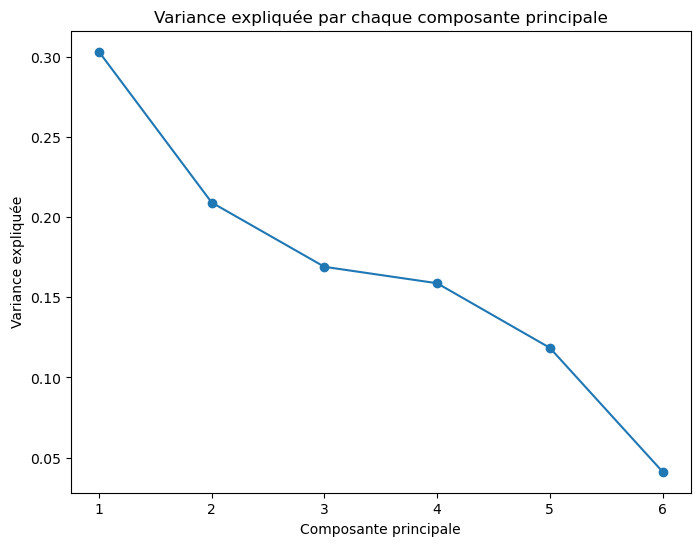

Nombre de composantes nécessaires pour expliquer 95% de la variance : 6


,game_id,game_date,home_team_id,period,time_in_period,event_id,event_type,is_goal,shot_type,x_coord,...,time_in_period_en_seconde,game_date_timestamp,shot_type_encoded,last_event_type_encoded,PC1,PC2,PC3,PC4,PC5,PC6
0,2016020518,2016-12-27,2,1,01:09,55,shot-on-goal,False,backhand,85.0,...,69,1482796800,0,9,-0.234080,-0.873860,1.140032,-1.681309,-0.451679,-0.086174
1,2016020518,2016-12-27,2,1,02:38,58,shot-on-goal,False,tip-in,-71.0,...,158,1482796800,4,0,-0.665873,0.486462,-0.106437,-0.939355,0.130856,-0.047159
2,2016020518,2016-12-27,2,1,03:44,61,shot-on-goal,False,slap,-36.0,...,224,1482796800,2,4,-0.525880,-0.763945,-0.343648,0.954961,-0.166065,-0.128621
3,2016020518,2016-12-27,2,1,04:12,64,shot-on-goal,False,wrist,-70.0,...,252,1482796800,6,9,1.096399,-5.460710,-0.139856,-0.001301,4.055280,-0.381376
4,2016020518,2016-12-27,2,1,04:21,67,shot-on-goal,False,tip-in,-72.0,...,261,1482796800,4,0,1.108371,-5.467891,-0.194602,-0.040814,4.052099,-0.380410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385020,2020020353,2021-03-01,28,3,10:57,741,shot-on-goal,False,wrist,-38.0,...,657,1614556800,6,5,-0.618780,-0.300174,-0.031240,0.398159,-0.501575,-0.094660
385021,2020020353,2021-03-01,28,3,18:10,757,shot-on-goal,False,wrist,-51.0,...,1090,1614556800,6,1,-0.797232,0.393225,-0.893247,0.618031,0.070008,-0.075052
385022,2020020353,2021-03-01,28,3,18:36,759,shot-on-goal,False,wrist,-55.0,...,1116,1614556800,6,9,-0.527313,-0.352105,-0.518819,0.121703,-0.628910,-0.085213
385023,2020020353,2021-03-01,28,3,18:45,761,shot-on-goal,False,wrist,-43.0,...,1125,1614556800,6,1,-0.648365,-0.269981,-0.587746,0.838973,-0.528812,-0.097562


In [25]:
# On choisit les colonnes numériques pertinentes pour l'ACP
columns_to_use = ['shooting_distance', 'speed_from_last_event','shot_angle','time_since_last_event','rebound_angle','rebound']

# Création d'un sous-ensemble avec seulement les colonnes numériques
df_numeric = df[columns_to_use]

# Standardisation des données : l'ACP est sensible à l'échelle des données, donc on les normalise
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Appliquer l'ACP pour réduire la dimensionnalité
pca = PCA(n_components=0.99)  # Choisir les composantes principales qui expliquent 95% de la variance
df_pca = pca.fit_transform(df_scaled)

# Affichage de la variance expliquée par chaque composante principale
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Variance expliquée par chaque composante principale')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.show()

# Afficher combien de composantes sont nécessaires pour expliquer 95% de la variance
print(f"Nombre de composantes nécessaires pour expliquer 95% de la variance : {len(pca.components_)}")

# Créer un DataFrame avec les nouvelles composantes principales
df_pca_df = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
df_1 = df.copy(deep=True)
df_1.reset_index(drop=True, inplace=True)
df_pca_df.reset_index(drop=True, inplace=True)

df_final = pd.concat([df_1, df_pca_df], axis=1)

# Vérifier les premières lignes du DataFrame avec les nouvelles composantes principales
df_final


In [26]:
print(pca.components_)

[[-0.18915928  0.20262178 -0.00400238 -0.18260281  0.66261052  0.67137968]
 [ 0.10581629 -0.66803779  0.01898612  0.67335207  0.23627835  0.18148686]
 [ 0.47016731  0.04731004  0.87444789 -0.08263972  0.0451336   0.05638255]
 [ 0.85390299  0.05900739 -0.48471406 -0.11925382  0.07950931  0.1089811 ]
 [ 0.05017548  0.71076122  0.00125139  0.70135799 -0.01810985  0.00826683]
 [-0.01721865 -0.04205117  0.00388746  0.01730231 -0.70458009  0.70794607]]


**Nous allons commencer à entrainer nos modèles**

Mais d'abord nous allons split nos données.

In [27]:
# Séparer les features (X) et la colonne cible (y)
X = df_final[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] 
y = df_final['is_goal']  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**Modèle de regression logistique**

In [28]:
# Créer un modèle de régression logistique
log_reg = LogisticRegression()

# Entraîner le modèle avec les données d'entraînement
log_reg.fit(X_train, y_train)

# Prédictions de probabilité pour la classe 1 (but)
y_pred = log_reg.predict_proba(X_val)[:, 1]

# Évaluation du modèle
roc_auc = roc_auc_score(y_val, y_pred)
roc_auc

0.6816341058318904

La métrique roc_auc n'est pas tres grande alors nous allons améliorer avec de l'hyperparamétrisation.

In [29]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Régularisation
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Type de pénalité
    'solver': ['liblinear', 'saga'],  # Solveurs adaptés
    'max_iter': [100, 200, 500]  # Nombre d'itérations
}
# Recherche de la meilleure combinaison d'hyperparametre avec RandomizedSearchCV
# RandomizedSearchCV pour hyperparamétrisation rapide
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_grid,
    n_iter=20,  # Nombre d'itérations aléatoires
    scoring='roc_auc',  # Optimiser l'AUC
    cv=3,  # Validation croisée sur 3 folds
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

# Meilleurs paramètres et performances
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Meilleurs paramètres :", best_params)
print("Meilleure AUC pendant la recherche :", best_score)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise

Meilleurs paramètres : {'solver': 'saga', 'penalty': None, 'max_iter': 500, 'C': 0.1}
Meilleure AUC pendant la recherche : 0.681886978707214


In [30]:
log_reg_best = LogisticRegression(**best_params)
log_reg_best.fit(X_train, y_train)

# Évaluer sur les données de validation
y_pred_best = log_reg_best.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_best)

print("AUC sur les données de validation :", roc_auc)


/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


AUC sur les données de validation : 0.681677462656859


In [31]:
class ProbabilisticModelVisualizer:
    def __init__(self, y_true, y_probs):
        """
        Initialise la classe avec les labels vrais et les probabilités prédites.
        
        :param y_true: Array-like, les labels vrais (0 ou 1).
        :param y_probs: Array-like, les probabilités prédites pour la classe 1.
        """
        self.y_true = np.array(y_true)
        self.y_probs = np.array(y_probs)

    def plot_roc_curve(self):
        """Trace la courbe ROC avec AUC."""
        fpr, tpr, _ = roc_curve(self.y_true, self.y_probs)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Classificateur Aléatoire')
        plt.xlabel('Taux de Faux Positifs')
        plt.ylabel('Taux de Vrais Positifs')
        plt.title('Courbe ROC sur l\'ensemble de validation')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    def plot_goal_rate_by_percentile(self):
        """Trace le taux de but par centile de probabilité."""
        probabilities = self.y_probs
        labels = self.y_true
        
        percentiles = np.percentile(probabilities, np.arange(0, 101, 10))
        rates = []
        for i in range(len(percentiles) - 1):
            mask = (probabilities >= percentiles[i]) & (probabilities < percentiles[i + 1])
            rate = np.mean(labels[mask]) if np.sum(mask) > 0 else 0
            rates.append(rate)
        
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(100, 0, -10), np.array(rates) * 100, marker='o', linestyle='-', color='b')
        plt.xticks(np.arange(100, 0, -10))
        plt.yticks(np.arange(0, 110, 10))
        plt.xlabel("Centile de probabilité du modèle de tir")
        plt.ylabel("Taux de but (%)")
        plt.title("Taux de but par centile de probabilité")
        plt.grid(True)
        plt.gca().invert_xaxis()
        plt.show()

    def plot_cumulative_goals_by_percentile(self):
        """Trace le pourcentage cumulé de buts par centile de probabilité."""
        probabilities = pd.Series(self.y_probs).reset_index(drop=True)
        labels = pd.Series(self.y_true).reset_index(drop=True)
        
        sorted_indices = np.argsort(probabilities)[::-1]
        sorted_labels = labels.iloc[sorted_indices]
        
        cumulative_goals = np.cumsum(sorted_labels) / np.sum(sorted_labels)
        percentiles = np.arange(1, len(cumulative_goals) + 1) / len(cumulative_goals) * 100
        
        plt.figure(figsize=(8, 6))
        plt.plot(percentiles, cumulative_goals, label="Modèle")
        plt.xticks(np.arange(100, 0, -10))
        plt.yticks(np.arange(0, 1.1, 0.1))
        plt.xlabel("Centile de probabilité du modèle de tir")
        plt.ylabel("Pourcentage cumulé de buts")
        plt.title("Pourcentage cumulé de buts par centile de probabilité")
        plt.legend()
        plt.grid(True)
        plt.gca().invert_xaxis()
        plt.show()

    def plot_calibration_curve(self):
        """Trace le diagramme de calibration."""
        plt.figure(figsize=(10, 6))
        CalibrationDisplay.from_predictions(self.y_true, self.y_probs, n_bins=10)
        plt.title('Diagramme de fiabilité (Courbe de calibration)')
        plt.grid(True)
        plt.show()

    def plot_f1_score_curve(self):
        
        thresholds = np.linspace(0, 1, 100)  # Liste de seuils entre 0 et 1
        f1_scores = []
    
        for threshold in thresholds:
            y_pred = (self.y_probs >= threshold).astype(int)  # Appliquer le seuil
            f1 = f1_score(self.y_true, y_pred)  # Calculer le F1-score
            f1_scores.append(f1)

        # Tracer la courbe
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, f1_scores, label="F1-score", color="green", lw=2)
        plt.xlabel("Seuil de décision")
        plt.ylabel("F1-score")
        plt.title("Évolution du F1-score en fonction du seuil de décision")
        plt.grid(True)
        plt.legend()
        plt.show()



In [32]:
visualisons_model_1 = ProbabilisticModelVisualizer(y_val,y_pred_best)

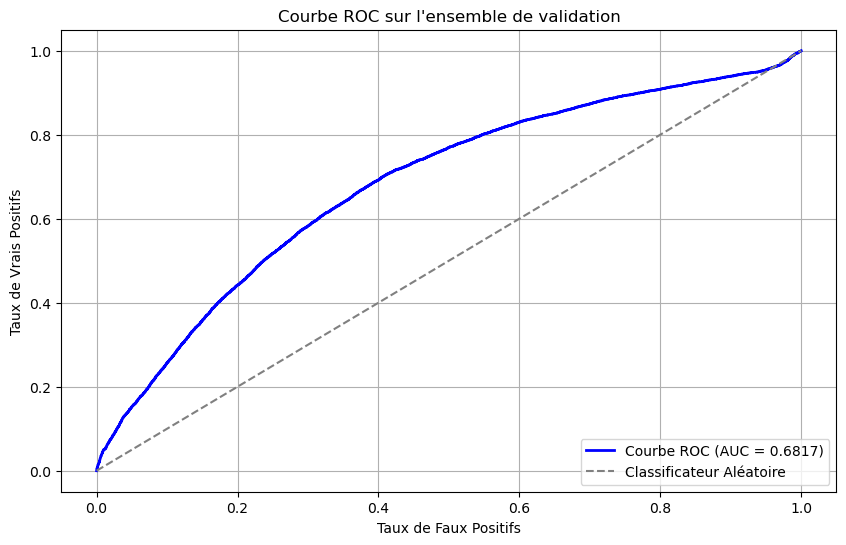

In [33]:
visualisons_model_1.plot_roc_curve()

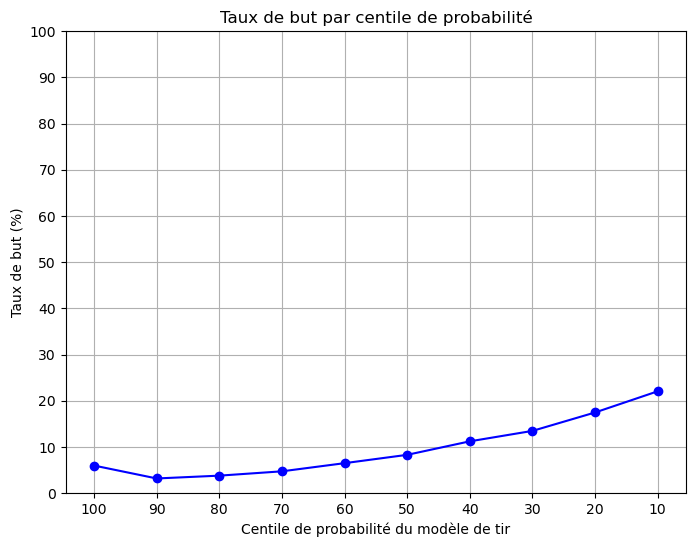

In [34]:
visualisons_model_1.plot_goal_rate_by_percentile()

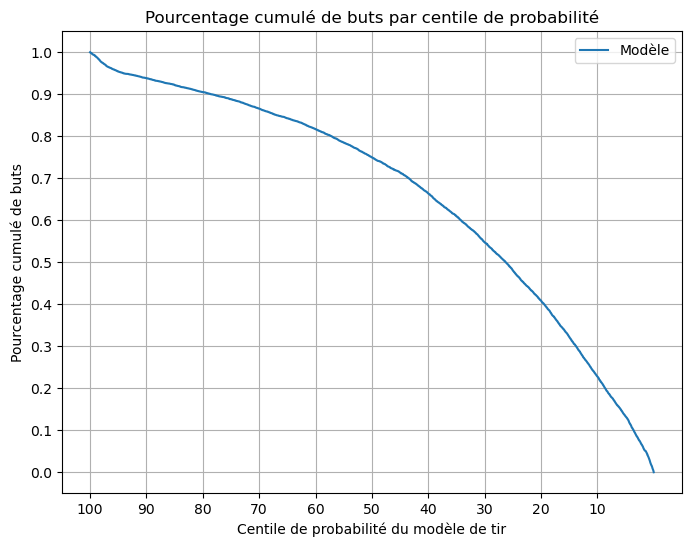

In [35]:
visualisons_model_1.plot_cumulative_goals_by_percentile()

<Figure size 1000x600 with 0 Axes>

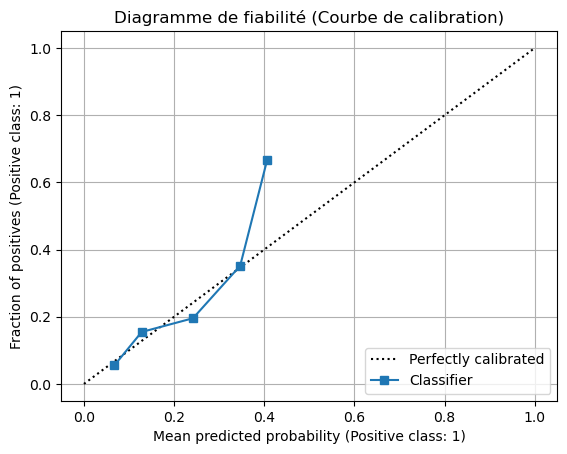

In [36]:
visualisons_model_1.plot_calibration_curve()

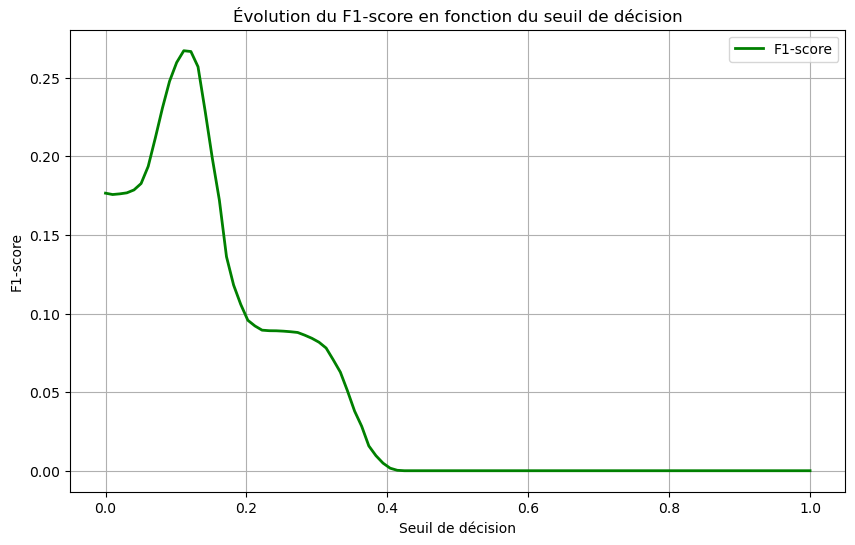

In [37]:
visualisons_model_1.plot_f1_score_curve()

**Modèle 2 DecisionTree**

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

# Modèle d'arbre de décision
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=6)  # Ajustez max_depth si nécessaire
decision_tree.fit(X_train, y_train)

# Prédictions de probabilités
y_pred = decision_tree.predict_proba(X_val)[:, 1]

# Évaluation
roc_auc = roc_auc_score(y_val, y_pred)
print(f"ROC AUC : {roc_auc:.4f}")

ROC AUC : 0.7117


On voit bien qu'avec ce modele on fait légerement mieux qu'avec la regression logistique. En plus à partir de 6 comme profondeur maximale la metrique ROC AUC stabilise autour de 0.71

In [39]:
visualisons_model_2 = ProbabilisticModelVisualizer(y_val,y_pred)

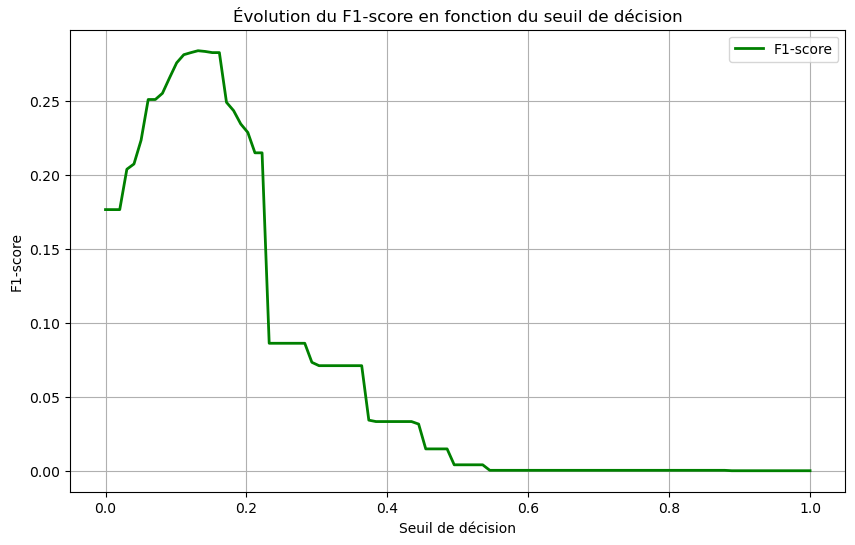

In [ ]:
visualisons_model_2.plot_f1_score_curve()

<Figure size 1000x600 with 0 Axes>

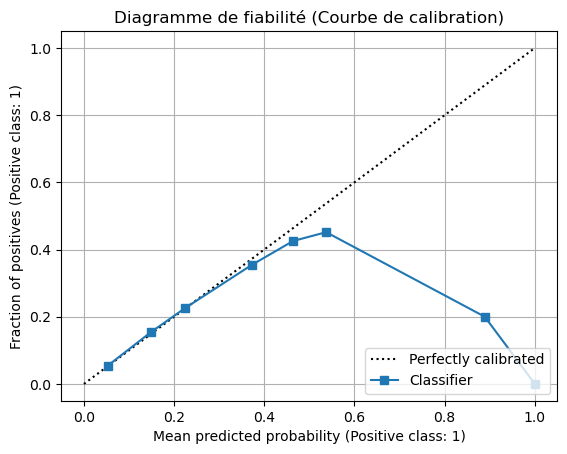

In [ ]:
visualisons_model_2.plot_calibration_curve()

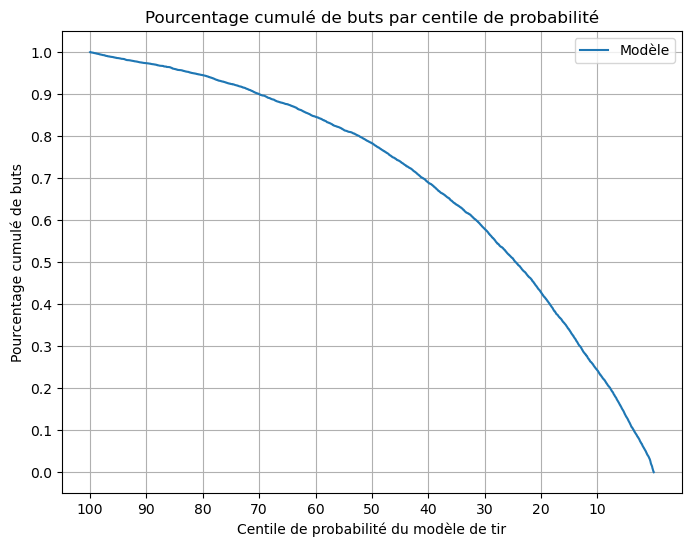

In [42]:

visualisons_model_2.plot_cumulative_goals_by_percentile()


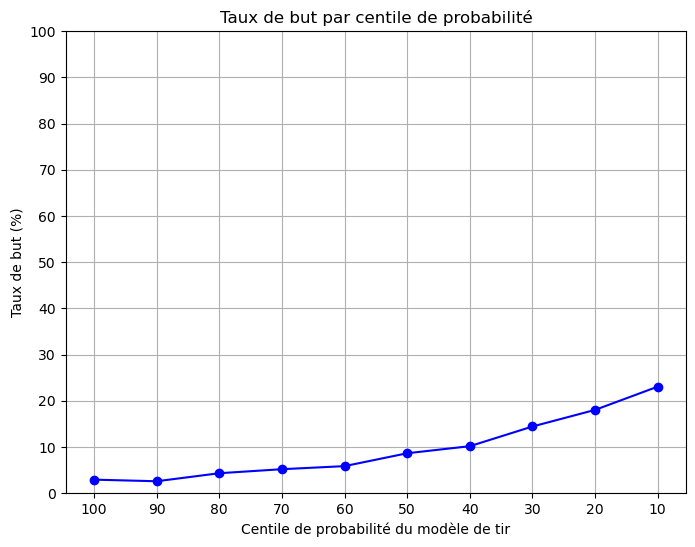

In [43]:

visualisons_model_2.plot_goal_rate_by_percentile()

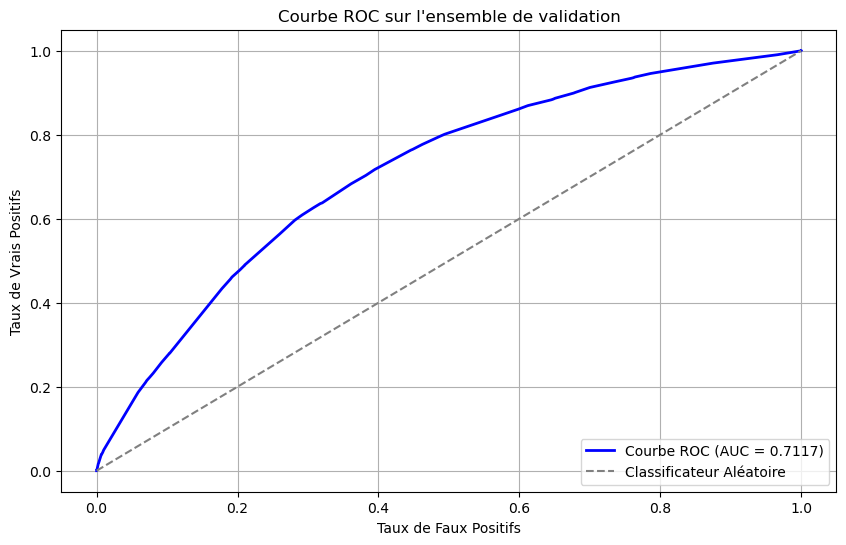

In [44]:

visualisons_model_2.plot_roc_curve()

**Modele 3: réseau de neurones**

In [45]:
# Recherche des meilleurs hyperparametres
from sklearn.model_selection import GridSearchCV

# Définir la grille d'hyperparamètres
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (32,)],  # Différentes tailles de couches
    'learning_rate_init': [0.01, 0.001, 0.0001],         # Différents taux d'apprentissage
    'alpha': [0.0001, 0.001, 0.01],                      # Paramètre de régularisation L2
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(
    estimator=MLPClassifier(max_iter=30, random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,  # Validation croisée à 3 plis
    verbose=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Rechercher les meilleurs hyperparamètres
grid_search.fit(X_train_scaled, y_train)

# Meilleurs hyperparamètres et performances
best_params = grid_search.best_params_
best_auc = grid_search.best_score_

print(f"Meilleurs paramètres: {best_params}")
print(f"Meilleur AUC: {best_auc:.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iter

Meilleurs paramètres: {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}
Meilleur AUC: 0.7322


/home/ing/Logiciels/anaconda3/envs/ift6758-conda-env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
# Récupérer les meilleurs hyperparamètres
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")


Meilleurs hyperparamètres : {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}


In [55]:
# Créer un nouveau modèle avec les meilleurs hyperparamètres
final_model = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    learning_rate_init=best_params['learning_rate_init'],
    alpha=best_params['alpha'],
    max_iter=80,
    random_state=42
)

# Réentraîner sur les données normalisées
final_model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble de validation
y_final_pred = final_model.predict_proba(X_val_scaled)[:, 1]

# Calculer l'AUC final
final_auc = roc_auc_score(y_val, y_final_pred_probs)
print(f"AUC après réentraînement : {final_auc:.4f}")


AUC après réentraînement : 0.7329


In [70]:
visualisons_model_3 = ProbabilisticModelVisualizer(y_val,y_final_pred)

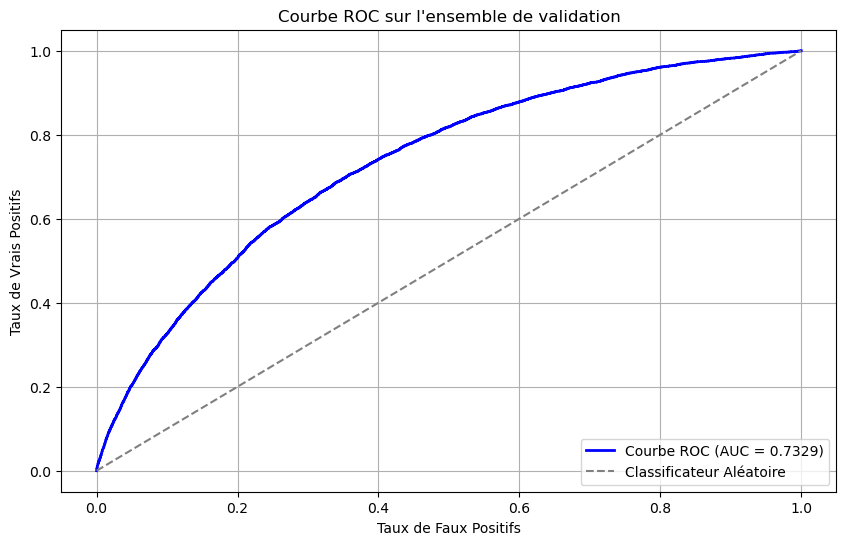

In [71]:
visualisons_model_3.plot_roc_curve()

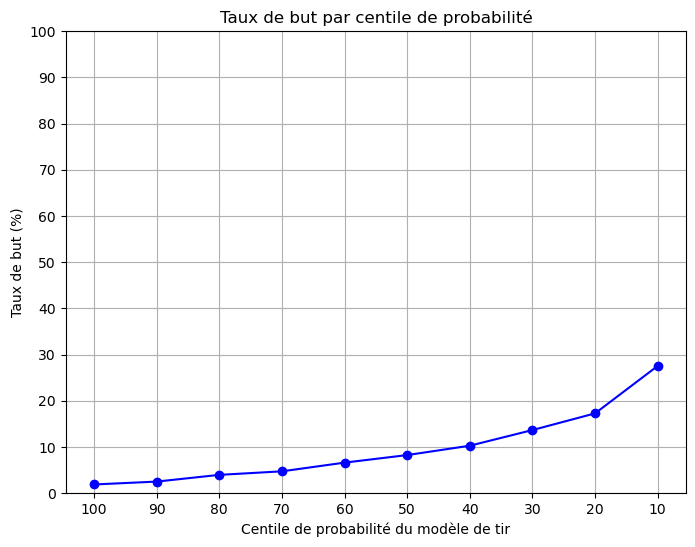

In [72]:
visualisons_model_3.plot_goal_rate_by_percentile()

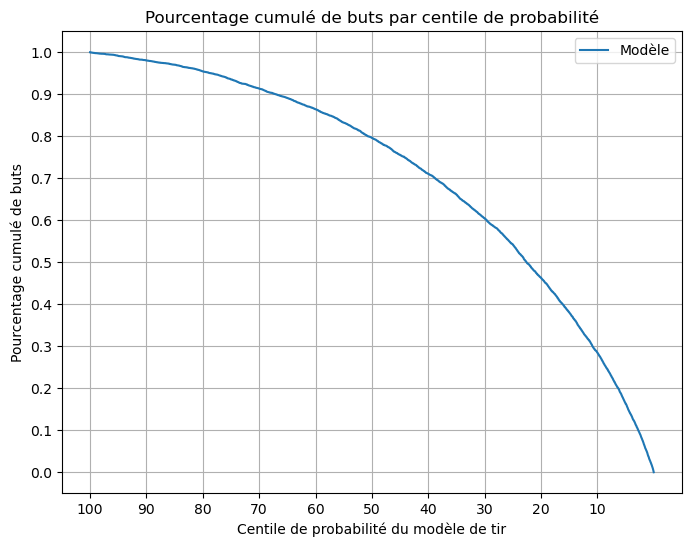

In [73]:
visualisons_model_3.plot_cumulative_goals_by_percentile()

<Figure size 1000x600 with 0 Axes>

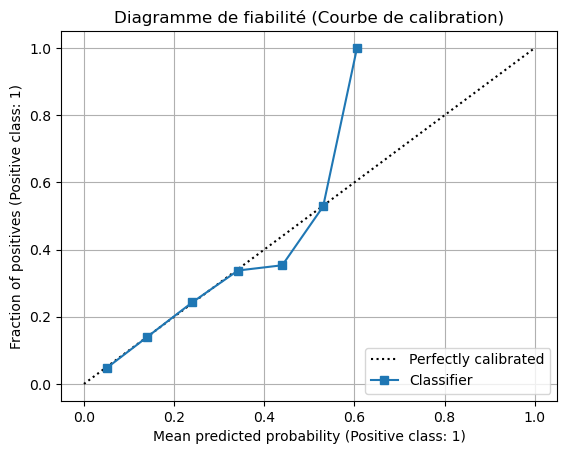

In [74]:
visualisons_model_3.plot_calibration_curve()

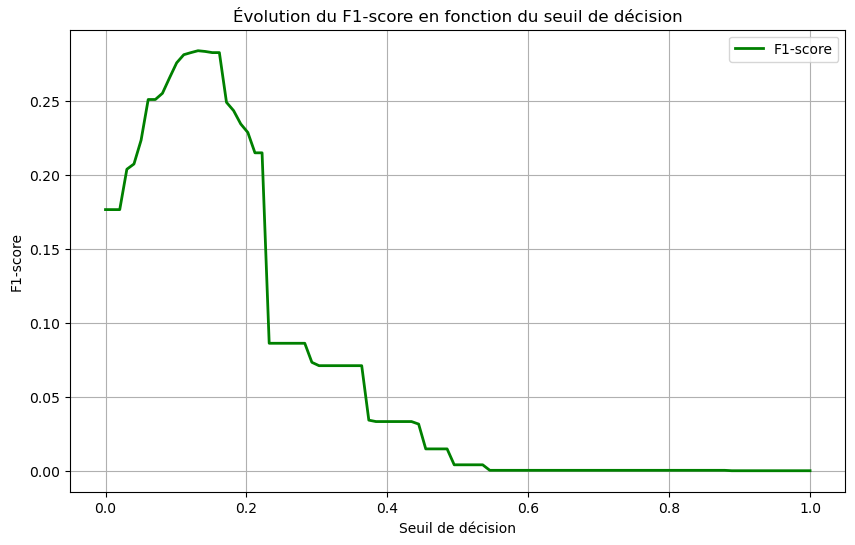

In [75]:
visualisons_model_2.plot_f1_score_curve()

**Modele 4 :Gradient Boosting**

In [94]:
param_grid = {
    'n_estimators': [50, 60],  # Nombre d'arbres
    'max_depth': [3, 5],         # Profondeur maximale des arbres
    'learning_rate': [0.01, 0.1],  # Taux d'apprentissage
    'subsample': [0.8, 1.0]         # Fraction d'échantillons pour chaque arbre
}


In [95]:
# Instanciation du modèle
model = LGBMClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # Validation croisée sur 3 plis
    verbose=1
)

# Entraîner sur les données d'entraînement
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[LightGBM] [Info] Number of positive: 19389, number of negative: 185957
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 205346, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094421 -> initscore=-2.260810
[LightGBM] [Info] Start training from score -2.260810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [92]:
# Modèle avec les meilleurs hyperparamètres
final_model_4 = LGBMClassifier(**best_params, random_state=42)

# Entraînement sur l'ensemble d'entraînement
final_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 29084, number of negative: 278936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 308020, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.094422 -> initscore=-2.260794
[LightGBM] [Info] Start training from score -2.260794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier(max_depth=5, n_estimators=60, random_state=42, subsample=0.8)

In [93]:
# Prédictions
y_pred = final_model_4.predict(X_val)

NotFittedError: Estimator not fitted, call fit before exploiting the model.

In [86]:
visualisons_model_4 = ProbabilisticModelVisualizer(y_val,y_pred)

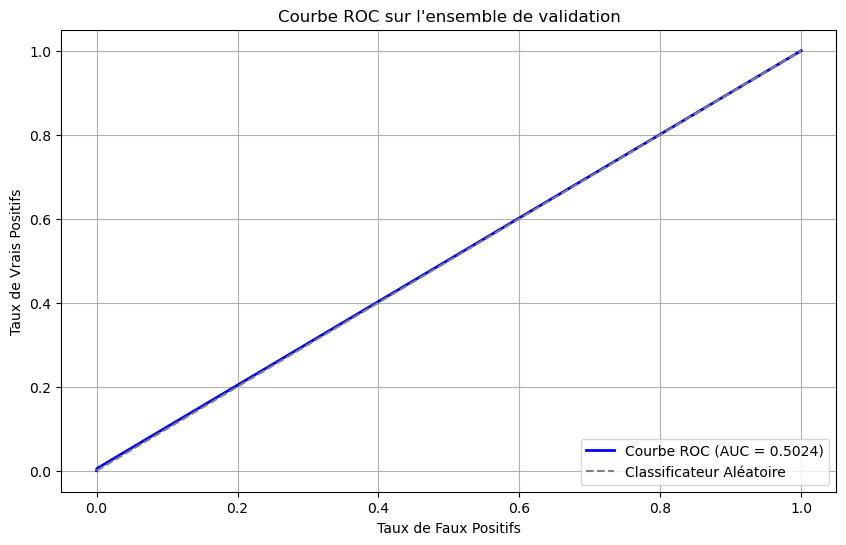

In [87]:

visualisons_model_4.plot_roc_curve()

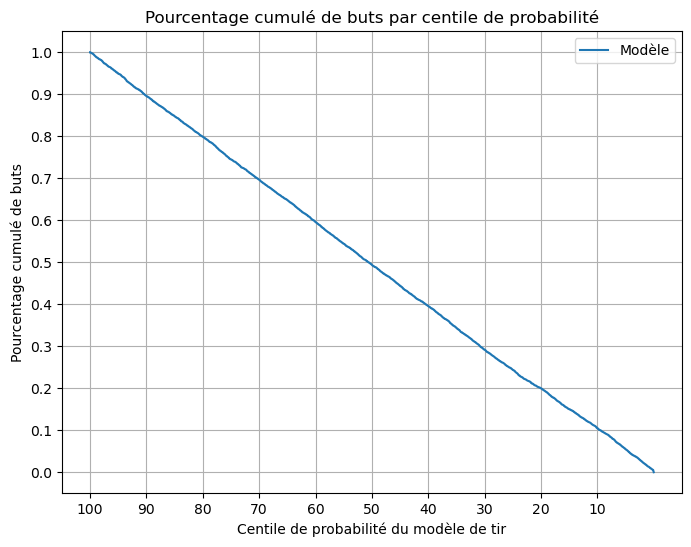

In [88]:
visualisons_model_4.plot_cumulative_goals_by_percentile()

<Figure size 1000x600 with 0 Axes>

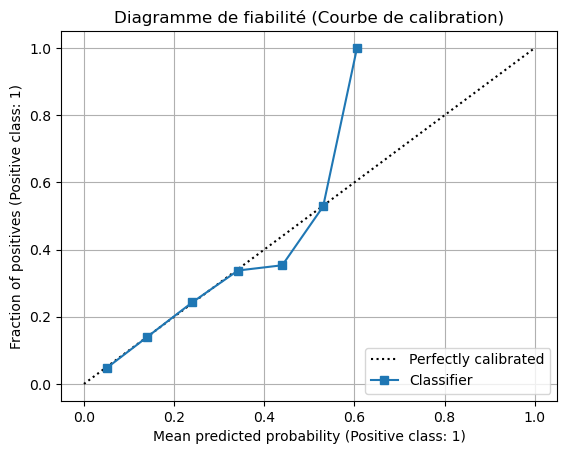

In [89]:
visualisons_model_3.plot_calibration_curve()

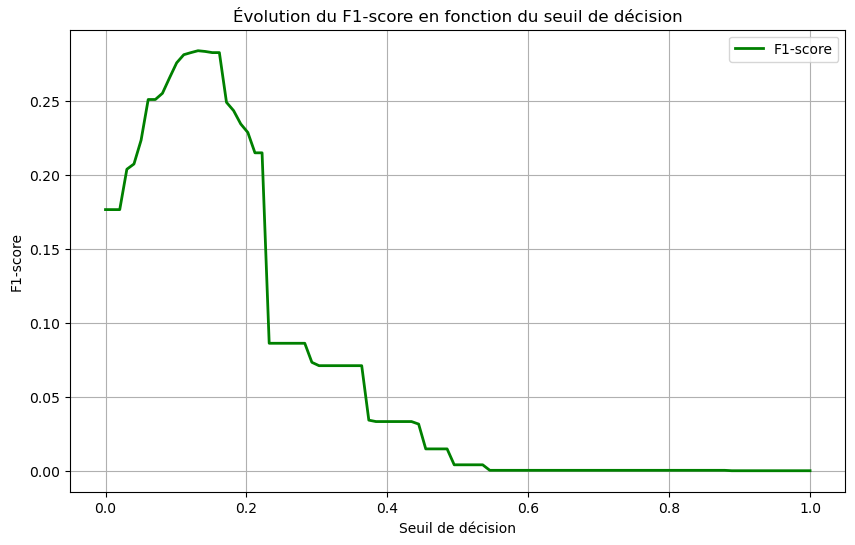

In [90]:
visualisons_model_2.plot_f1_score_curve()

On retient au final le modele_3 réseau de neuronnes qui a les meilleures metriques malgré son temps d'apprentissage des hyperparametres optimaux.